<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

<b>Описание проекта</b>  

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется постройть модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам надо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# Импортируем библиотеки
import warnings

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (RandomizedSearchCV,
                                     TimeSeriesSplit,
                                     train_test_split)
from tqdm import trange

warnings.filterwarnings("ignore")

In [2]:
# Определим константы
RANDOM_STATE = 42
TSCV = TimeSeriesSplit(n_splits=5)

In [3]:
# Читаем данные из csv-файла и сохраним в переменную
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
# Изучим общую информацию о полученном датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Приведем данные к удобному формату
df = pd.read_csv(('https://code.s3.yandex.net/datasets/taxi.csv'), parse_dates=['datetime'])

In [6]:
# Установим индекс таблицы равным столбцу 'datetime'
df.set_index('datetime', inplace=True)

In [7]:
# Отсортируем индекс таблицы 
df.sort_index(inplace=True)

In [8]:
# Проверим в хронологическом ли порядке расположены даты и время
print(df.index.is_monotonic)

True


In [9]:
#  Проверим общую информацию
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Т.к. нам необходимо спрогнозировать заказы такси на следующий час, поменяем интервал и сгруппируем значения по 1 часу.

In [10]:
# Выполним ресемплирование
df = df.resample('1H').sum()

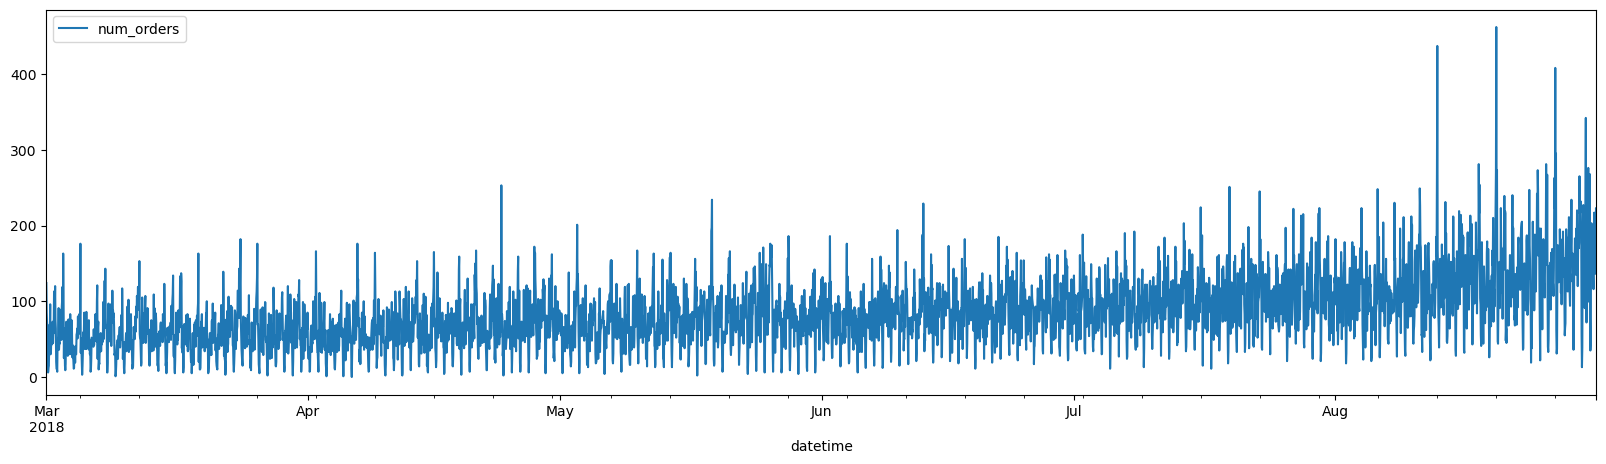

In [11]:
# Построим график временного ряда
plt.figure(figsize=(20,5))
df.plot(ax=plt.gca());

На этапе подготовки датасета мы изменили тип данных столбца 'datetime' с object на datetime64. Установили индекс таблицы равным столбцу 'datetime' и сделали его сортировку. Проверили, что даты и время расположены даты и время в хронологическом порядке. Т.к. нам необходимо спрогнозировать заказы такси на следующий час, поменяли интервал и сгруппировали значения по 1 часу, выполнив ресемплирование. Построили график временного ряда.  


## Анализ

In [12]:
# Добавим столбец скользящего среднего с разбивкой на недельные заказы
df['rolling_mean'] = df.rolling(168).mean()

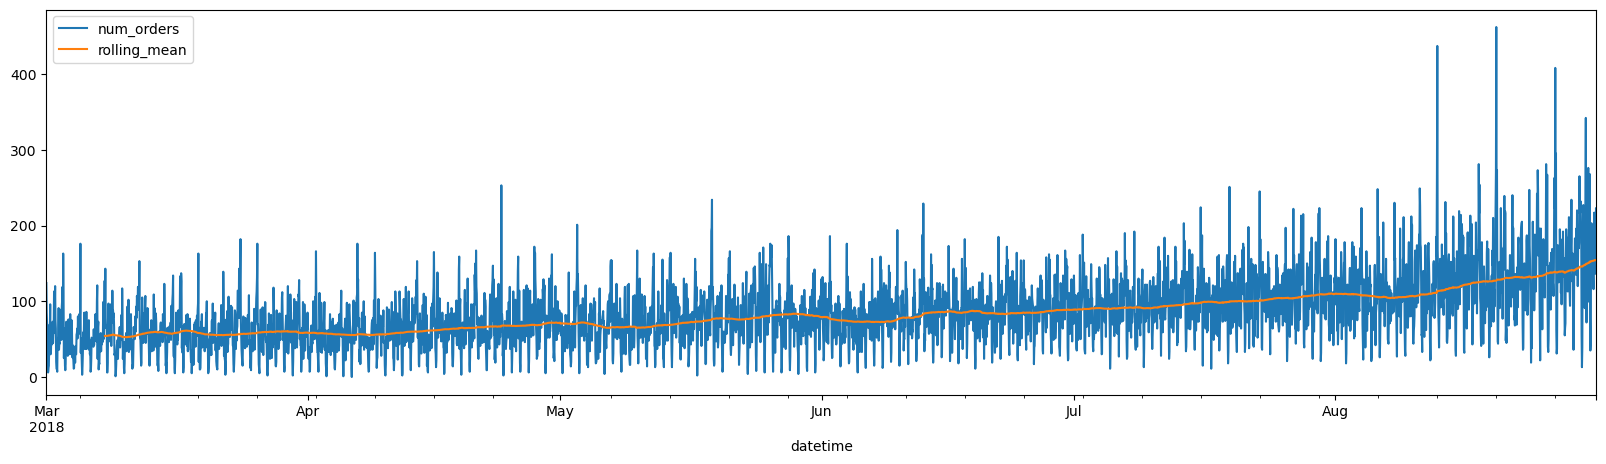

In [13]:
# Построим график
plt.figure(figsize=(20,5))
df.plot(ax=plt.gca());

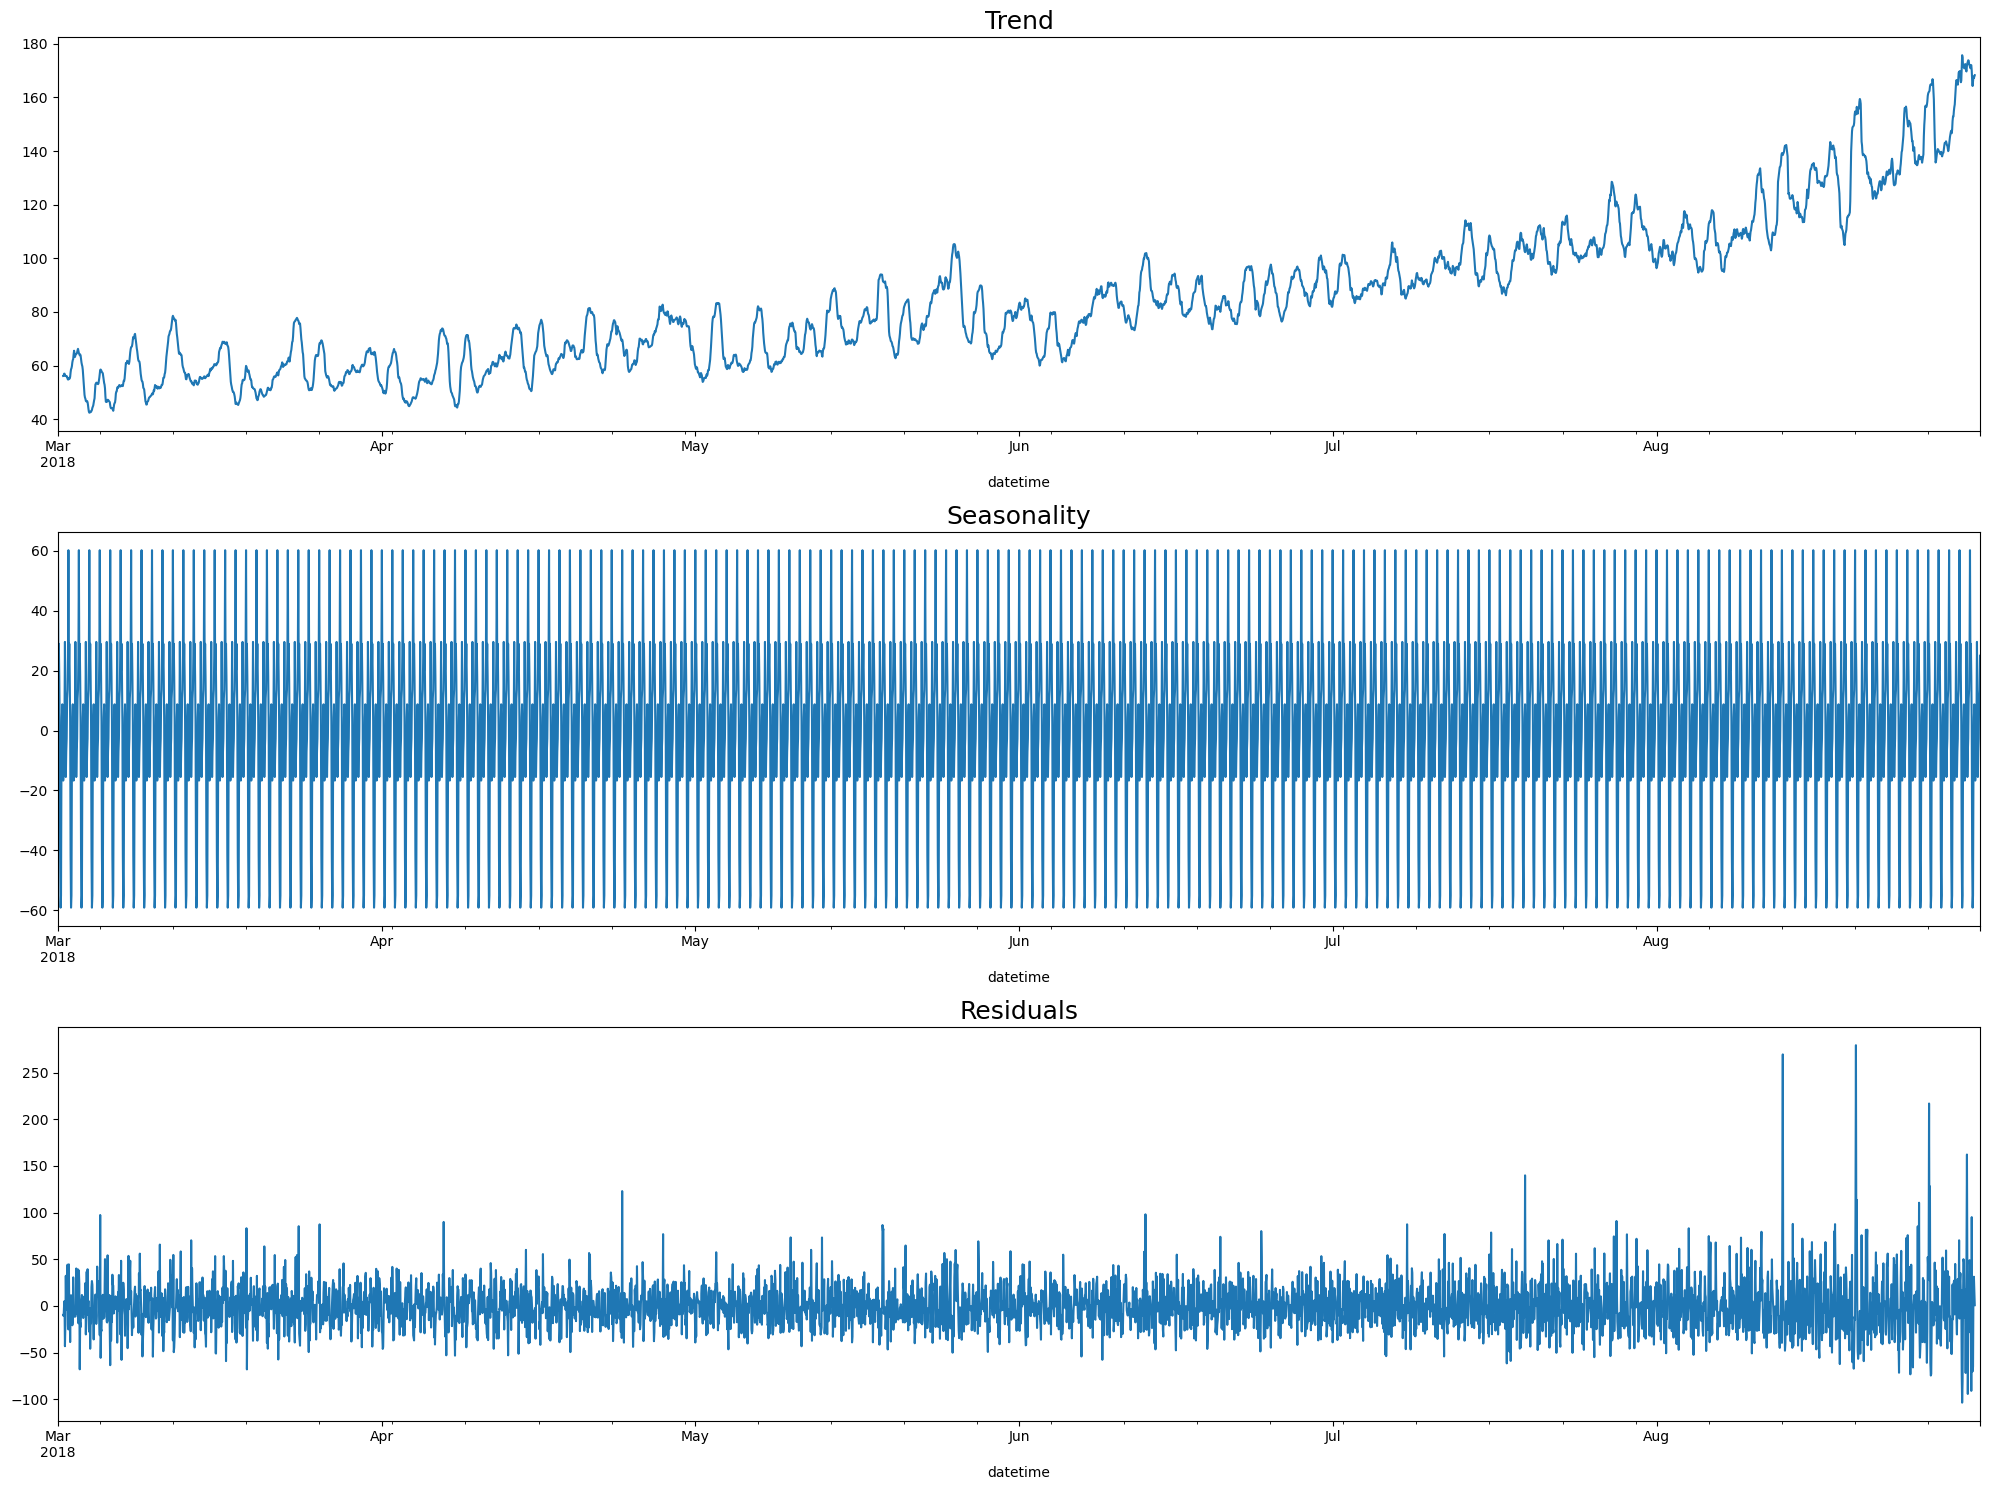

In [16]:
# Декомпозируем наши данные для просмотра наличия тренда, сезонности и остатков
decomposed = seasonal_decompose(df.drop(['rolling_mean'], axis = 1))
plt.figure(figsize=(20,15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', fontsize=18)
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality', fontsize=18)
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals', fontsize=18)
plt.tight_layout()

Наблюдается тренд на увеличение заказов такси в течении года.

Исследуем сезонность заказов такси менее месяца. 

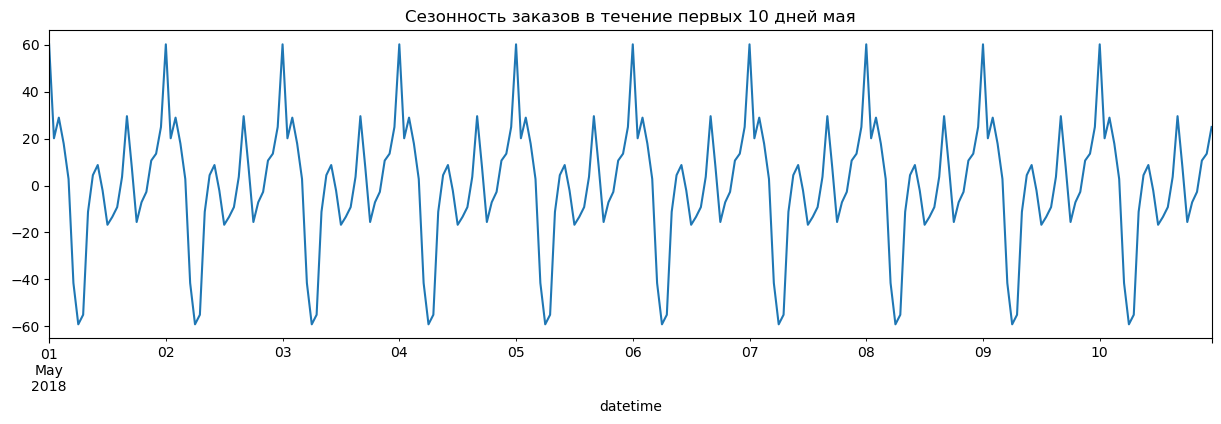

In [17]:
# Построим график
plt.figure(figsize=(15,4))
plt.title('Сезонность заказов в течение первых 10 дней мая')
decomposed.seasonal['2018-05-01':'2018-05-10'].plot(ax=plt.gca());

Наблюдаем ежедневный рост заказов такси с утра до полуночи.

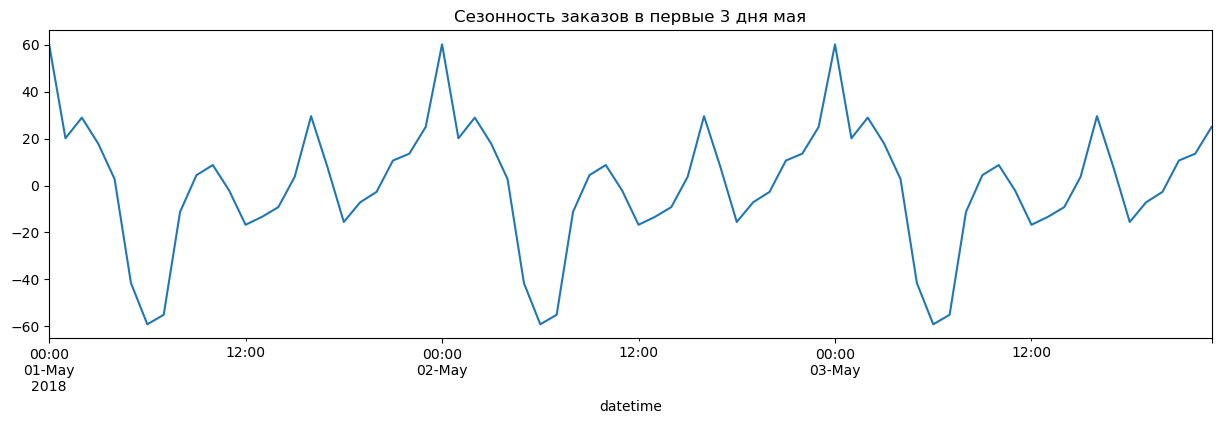

In [18]:
# Построим график
plt.figure(figsize=(15,4))
plt.title('Сезонность заказов в первые 3 дня мая')
decomposed.seasonal['2018-05-01':'2018-05-03'].plot(ax=plt.gca());

Наблюдаем постепенное увеличение заказов с 6 утра, пик заказов в полночь и более резкий спад заказов к 6 утра.

На этапе анализа датасета мы добавим столбец скользящего среднего с разбивкой на недельные заказы. Декомпозировали наши данные для просмотра наличия тренда, сезонности и остатков. Наблюдается тренд на увеличение заказов такси в течении года.  
Далее мы исследовали сезонность заказов такси менее месяца. Построили график сезонности заказов в течение первых 10 дней мая, по которому наблюдается ежедневный рост заказов такси с утра до полуночи. Построили график сезонность заказов в первые 3 дня мая, по которому наблюдается постепенное увеличение заказов с 6 утра, пик заказов в полночь и более резкий спад заказов к 6 утра.

## Обучение

In [19]:
# Напишем функцию для создания признаков
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
# Добавим признаки 
data = make_features(df, 24, 7)
print(data.head())

                     num_orders  rolling_mean  year  month  day  dayofweek  \
datetime                                                                     
2018-03-01 00:00:00         124           NaN  2018      3    1          3   
2018-03-01 01:00:00          85           NaN  2018      3    1          3   
2018-03-01 02:00:00          71           NaN  2018      3    1          3   
2018-03-01 03:00:00          66           NaN  2018      3    1          3   
2018-03-01 04:00:00          43           NaN  2018      3    1          3   

                     lag_1  lag_2  lag_3  lag_4  ...  lag_15  lag_16  lag_17  \
datetime                                         ...                           
2018-03-01 00:00:00    NaN    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 01:00:00  124.0    NaN    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 02:00:00   85.0  124.0    NaN    NaN  ...     NaN     NaN     NaN   
2018-03-01 03:00:00   71.0   85.0  124.0    NaN  ... 

In [21]:
# Разобьем данные на тренировочную и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [22]:
# Проверим как поделились данные
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [23]:
# Из обучающей выборки удалим строки с пропусками
train = train.dropna()
# Проверим пропуски в обучающей выборке
train.isna().sum()

num_orders      0
rolling_mean    0
year            0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
dtype: int64

In [24]:
# Проверим размер выборок
print(train.shape)
print(test.shape)

(3950, 30)
(442, 30)


In [25]:
# Разобьем данные data на признаки и целевой признак, сохраним в отдельных переменных
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders'] 

Для обучения моделей применим следующие библиотеки: LinearRegression, RandomForestRegressor, CatboostRegressor и LightGBMRegressor.

### LinearRegression

In [28]:
%%time

model_lr = LinearRegression()

# Создадим пайплайн
pipeline_lr = Pipeline([('linearregression', model_lr)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lr = {'linearregression__fit_intercept':[True,False]}
                 
# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lr = RandomizedSearchCV(estimator=pipeline_lr, 
                           param_distributions=param_grid_lr, 
                           scoring='neg_root_mean_squared_error',
                           cv=TSCV,
                           n_iter=20,
                           n_jobs=-1, 
                           random_state=RANDOM_STATE,
                           verbose=10)

random_cv_lr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 188 ms
Wall time: 2.73 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('linearregression',
                                              LinearRegression())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'linearregression__fit_intercept': [True,
                                                                            False]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [29]:
random_cv_lr_best_score = - random_cv_lr.best_score_.round(3) 
random_cv_lr_best_params = random_cv_lr.best_params_

# Лучшее значение RMSE 
print(f'best_score: {random_cv_lr_best_score}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_lr_best_params}')

best_score: 27.02
best_params: {'linearregression__fit_intercept': False}


### RandomForestRegressor

In [30]:
%%time

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Создадим пайплайн
pipeline_rf = Pipeline([('randomforestregressor', model_rf)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_rf = {'randomforestregressor__n_estimators': range(2, 51, 2),
                 'randomforestregressor__max_depth': range(2, 15),
                 'randomforestregressor__min_samples_split': (2, 3, 4),
                 'randomforestregressor__min_samples_leaf': (1, 2, 3, 4)}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_rf = RandomizedSearchCV(estimator=pipeline_rf, 
                           param_distributions=param_grid_rf, 
                           scoring='neg_root_mean_squared_error',
                           cv=TSCV,
                           n_iter=20,
                           n_jobs=-1, 
                           random_state=RANDOM_STATE,
                           verbose=10)

random_cv_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 2.83 s
Wall time: 13.6 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': range(2, 15),
                                        'randomforestregressor__min_samples_leaf': (1,
                                                                                    2,
                                                                                    3,
                                                                                    4),
                                        'randomforestregressor__min_samples_split': (2,
                                                                                     3,
                                                                                     4),
                                        'randomforestregressor__n_estimators': range(2, 51, 2)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [31]:
random_cv_rf_best_score = - random_cv_rf.best_score_.round(3) 
random_cv_rf_best_params = random_cv_rf.best_params_

# Лучшее значение RMSE 
print(f'best_score: {random_cv_rf_best_score}')
# Лучшие гиперпараметры
print(f'best_params: {random_cv_rf_best_params}')

best_score: 25.859
best_params: {'randomforestregressor__n_estimators': 40, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_depth': 13}


### LightGBMRegressor

In [32]:
%%time

model_lgbm = LGBMRegressor(objective='regression',
                           boosting_type='gbdt',
                           random_state=RANDOM_STATE)
# Создадим пайплайн                        
pipeline_lgbm = Pipeline([('lightgbmregressor', model_lgbm)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_lgbm = {'lightgbmregressor__n_estimators': range(2, 51, 2),
                   'lightgbmregressor__max_depth': range(2, 15),
                   'lightgbmregressor__num_leaves': [25, 50, 100, 200],
                   'lightgbmregressor__learning_rate': [.1, .3, .5]}

# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_lgbm = RandomizedSearchCV(estimator=pipeline_lgbm, 
                                    param_distributions=param_grid_lgbm, 
                                    scoring='neg_root_mean_squared_error',
                                    cv=TSCV,
                                    n_iter=20,
                                    n_jobs=-1, 
                                    random_state=RANDOM_STATE,
                                    verbose=10)

random_cv_lgbm.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4851
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 28
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('lightgbmregressor',
                                              LGBMRegressor(objective='regression',
                                                            random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'lightgbmregressor__learning_rate': [0.1,
                                                                             0.3,
                                                                             0.5],
                                        'lightgbmregressor__max_depth': range(2, 15),
                                        'lightgbmregressor__n_estimators': range(2, 51, 2),
                                        'lightgbmregressor__num_leaves': [25,
                                                                          50,
                                                                          100,
                                                                          200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [33]:
random_cv_lgbm_best_score = - random_cv_lgbm.best_score_.round(3)
random_cv_lgbm_best_params = random_cv_lgbm.best_params_

# лучшее значение RMSE 
print(f'best_score: {random_cv_lgbm_best_score}')
# лучшие гиперпараметры
print(f'best_params: {random_cv_lgbm_best_params}')

best_score: 25.682
best_params: {'lightgbmregressor__num_leaves': 200, 'lightgbmregressor__n_estimators': 48, 'lightgbmregressor__max_depth': 12, 'lightgbmregressor__learning_rate': 0.1}


### CatBoostRegressor

In [34]:
%%time

model_cbr = CatBoostRegressor(random_state=RANDOM_STATE)          
                              
# Создадим пайплайн 
pipeline_cbr = Pipeline([('catboostregressor', model_cbr)])

# Cловарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_cbr = {'catboostregressor__n_estimators': range(2, 51, 2),
                  'catboostregressor__max_depth': range(2, 15),
                  'catboostregressor__learning_rate': [.1, .3, .5]}


# Будем использовать RandomizedSearchCV при переборе комбинаций гиперпараметров
random_cv_cbr = RandomizedSearchCV(estimator=pipeline_cbr, 
                                   param_distributions=param_grid_cbr, 
                                   scoring='neg_root_mean_squared_error',
                                   cv=TSCV,
                                   n_iter=20,
                                   n_jobs=-1, 
                                   random_state=RANDOM_STATE,
                                   verbose=10)

random_cv_cbr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0:	learn: 33.6281238	total: 152ms	remaining: 5.3s
1:	learn: 30.2944718	total: 158ms	remaining: 2.68s
2:	learn: 27.9905284	total: 170ms	remaining: 1.87s
3:	learn: 26.5492821	total: 178ms	remaining: 1.43s
4:	learn: 25.3725150	total: 185ms	remaining: 1.15s
5:	learn: 24.6856958	total: 191ms	remaining: 954ms
6:	learn: 24.1371800	total: 198ms	remaining: 820ms
7:	learn: 23.6255255	total: 205ms	remaining: 716ms
8:	learn: 23.2540915	total: 211ms	remaining: 633ms
9:	learn: 22.9569729	total: 218ms	remaining: 566ms
10:	learn: 22.8994347	total: 225ms	remaining: 510ms
11:	learn: 22.8523422	total: 232ms	remaining: 464ms
12:	learn: 22.4879524	total: 239ms	remaining: 422ms
13:	learn: 22.3610742	total: 245ms	remaining: 385ms
14:	learn: 22.1901317	total: 251ms	remaining: 351ms
15:	learn: 22.1314492	total: 256ms	remaining: 320ms
16:	learn: 21.9476258	total: 262ms	remaining: 293ms
17:	learn: 21.7593472	total: 267ms	remaining: 267ms
18:	learn: 21

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('catboostregressor',
                                              <catboost.core.CatBoostRegressor object at 0x0000028C2CDD1C00>)]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'catboostregressor__learning_rate': [0.1,
                                                                             0.3,
                                                                             0.5],
                                        'catboostregressor__max_depth': range(2, 15),
                                        'catboostregressor__n_estimators': range(2, 51, 2)},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=10)

In [35]:
random_cv_cbr_best_score = - random_cv_cbr.best_score_.round(3)
random_cv_cbr_best_params = random_cv_cbr.best_params_

# лучшее значение RMSE 
print(f'best_score: {random_cv_cbr_best_score}')
# лучшие гиперпараметры
print(f'best_params: {random_cv_cbr_best_params}')

best_score: 25.868
best_params: {'catboostregressor__n_estimators': 36, 'catboostregressor__max_depth': 7, 'catboostregressor__learning_rate': 0.3}


Для обучения моделей мы применили следующие библиотеки: LinearRegression, RandomForestRegressor, CatboostRegressor и LightGBMRegressor. Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения минимальной оценки метрики RMSE. 

In [36]:
# Объеденим данные в одну таблицу
result = pd.DataFrame([random_cv_lr_best_score,
                       random_cv_rf_best_score,
                       random_cv_lgbm_best_score,
                       random_cv_cbr_best_score], 
                       index=['LinearRegression',
                              'RandomForestRegressor',
                              'LightGBMRegressor',
                              'CatBoostRegressor'], 
                       columns=['RMSE'])
result

,RMSE
LinearRegression,27.020
RandomForestRegressor,25.859
LightGBMRegressor,25.682
CatBoostRegressor,25.868


Наилучшей моделью стала LightGBMRegressor с минимальным показалем RMSE на тренировочной выборке - 25.682.

На этапе обучения мы написали функцию для создания календарных признаков, признаков «Отстающих значений» и  скользящего среднего, добавили данные признаки. Разобили данные на тренировочную и тестовую выборки. Из обучающей выборки удалили строки с пропусками. Разобили данные data на признаки и целевой признак, сохранили в отдельных переменных.  
Для обучения моделей мы применили следующие библиотеки: LinearRegression, RandomForestRegressor, CatboostRegressor и LightGBMRegressor. Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения минимальной оценки метрики RMSE. Наилучшей моделью стала LightGBMRegressor с минимальным показалем RMSE на тренировочной выборке - 25.682.  

## Тестирование

Проверим результаты выбранной модели на тестовой выборке.

In [37]:
# Инициируем модель с лучшими параметрами
best_model_lgbm = LGBMRegressor(max_depth=12,
                                num_leaves=200,
                                n_estimators=48,
                                learning_rate=0.1,
                                random_state=42)              

In [38]:
best_model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4851
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 28
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(max_depth=12, n_estimators=48, num_leaves=200, random_state=42)

In [39]:
predict_lgbm_best = best_model_lgbm.predict(X_test)

In [40]:
rmse = mean_squared_error(y_test, predict_lgbm_best, squared=False)
print('Метрика RMSE на тестовой выборке для модели LightGBMRegressor составила', rmse.round(3))

Метрика RMSE на тестовой выборке для модели LightGBMRegressor составила 42.665


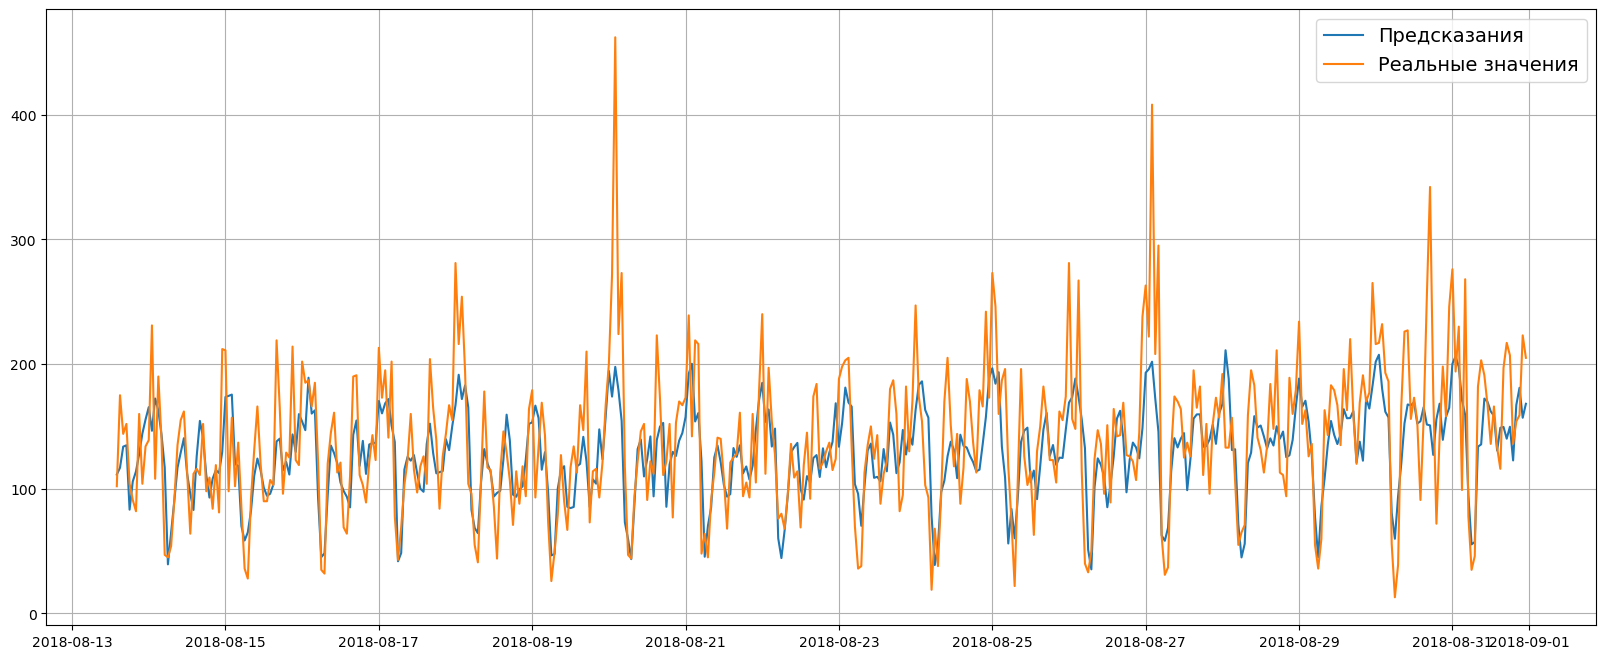

In [41]:
# Построим график предсказанных значений лучшей модели и реальных тестовых
plt.figure(figsize=(20,8))
plt.plot(y_test.index, predict_lgbm_best, label='Предсказания')
plt.plot(y_test.index, y_test.values, label='Реальные значения')
plt.legend(loc="upper right", fontsize=14)
plt.grid(True)    

Мы проверили результаты лучшей модели LightGBMRegressor на тестовой выборке. Метрика RMSE на тестовой выборке для модели LightGBMRegressor составила 42.665.  

## Общий вывод

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки.  
Было проведено исследование, чтобы спрогнозировать количество заказов такси на следующий час. Нам надо было построить модель со значением метрики RMSE на тестовой выборке не больше 48.  
На этапе подготовки датасета мы изменили тип данных столбца 'datetime' с object на datetime64. Установили индекс таблицы равным столбцу 'datetime' и сделали его сортировку. Проверили, что даты и время расположены даты и время в хронологическом порядке. Т.к. нам необходимо спрогнозировать заказы такси на следующий час, поменяли интервал и сгруппировали значения по 1 часу, выполнив ресемплирование. Построили график временного ряда.   
На этапе анализа датасета мы добавим столбец скользящего среднего с разбивкой на недельные заказы. Декомпозировали наши данные для просмотра наличия тренда, сезонности и остатков. Наблюдается тренд на увеличение заказов такси в течении года.
Далее мы исследовали сезонность заказов такси менее месяца. Построили график сезонности заказов в течение первых 10 дней мая, по которому наблюдается ежедневный рост заказов такси с утра до полуночи. Построили график сезонность заказов в первые 3 дня мая, по которому наблюдается постепенное увеличение заказов с 6 утра, пик заказов в полночь и более резкий спад заказов к 6 утра.  
На этапе обучения мы написали функцию для создания календарных признаков, признаков «Отстающих значений» и скользящего среднего, добавили данные признаки. Разобили данные на тренировочную и тестовую выборки. Из обучающей выборки удалили строки с пропусками. Разобили данные data на признаки и целевой признак, сохраним в отдельных переменных.  
Для обучения моделей мы применили следующие библиотеки: LinearRegression, RandomForestRegressor, CatboostRegressor и LightGBMRegressor. Для каждой модели мы подбирали оптимальные гиперпараметры с целью получения минимальной оценки метрики RMSE. Наилучшей моделью стала LightGBMRegressor с минимальным показалем RMSE на тренировочной выборке - 25.682.   
Мы проверили результаты лучшей модели LightGBMRegressor на тестовой выборке.  
По итогам анализа результатов было принято решение рекомендовать заказчику модель LightGBMRegressor с минимальным показалем RMSE на тестовой выборке - 42.665.

